In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
# Load the dataset
df = pd.read_csv('../manager-course-completion-by-user.csv')

# Filter AP CSP Courses
courses = [
	'Getting Started (AP CSP CodeCombat)',
	'Module 1 (AP CSP CodeCombat) - Course Overview',
	'Module 2 (AP CSP CodeCombat) - Recruitment Strategies',
	'Module 3 (AP CSP CodeCombat) - The Structure of Quests',
	'Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1',
	'Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2',
	'Module 6 (AP CSP CodeCombat) - The Create Task',
	'Module 7 (AP CSP CodeCombat) - The Multiple Choice Exam',
	'Module 8 (AP CSP CodeCombat) - Completing the Course Audit',
#  '(Optional) Module 9 (AP CSP CodeCombat) - Exploring CodeCombat Capstone Projects'
]

# Getting Started 11
# M1: 57.5
# M2: 33.5
# M3: 47.5
# M4: 61
# M5: 38.5
# M6: 28.5
# M7: 35
# M8: 22
# M9: 45

expected_time_spent = {
	'Getting Started (AP CSP CodeCombat)': 11,
	'Module 1 (AP CSP CodeCombat) - Course Overview': 57.5,
	'Module 2 (AP CSP CodeCombat) - Recruitment Strategies': 33.5,
	'Module 3 (AP CSP CodeCombat) - The Structure of Quests': 47.5,
	'Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1': 61,
	'Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2': 38.5,
	'Module 6 (AP CSP CodeCombat) - The Create Task': 28.5,
	'Module 7 (AP CSP CodeCombat) - The Multiple Choice Exam': 35,
	'Module 8 (AP CSP CodeCombat) - Completing the Course Audit': 22,
	'(Optional) Module 9 (AP CSP CodeCombat) - Exploring CodeCombat Capstone Projects': 45
}

df = df[df['Course'].isin(courses)]

# Remove rows with email sonia@codecombat.com
df = df[df['Email'] != 'sonia@codecombat.com']

# Convert 'Time Spent' to minutes for easier analysis
# df['Time Spent (min)'] = df['Time Spent (h mm)'].apply(lambda x: int(x.split('h')[0]) * 60 + int(x.split('h')[1].replace('m', '')))

# Handling NaN values - here, we'll drop rows where essential information is missing. Adapt this as necessary.
# df.dropna(subset=['Date Completed', 'Time Spent (min)', 'Average Score', 'Progress (Percent)'], inplace=True)

In [61]:
df.shape

(2097, 30)

In [3]:
df.columns

Index(['UserID', 'User Details', 'Username', 'Email', 'User Groups',
       'First Name', 'Last Name', 'CourseID', 'Course', 'Language',
       'Training Mode', 'Due Date', 'Date Completed', 'Time Completed',
       'Completion Date', 'Required Lessons Completed', 'Required Lessons',
       'Time Spent', 'Time Spent (h mm)', 'Average Score', 'Progress',
       'Progress (%)', 'Progress (Percent)', 'Full name',
       'Time Spent (minutes)', 'User Status', 'Assigned Status',
       'SECONDARY_DISPLAY_NAME', 'Completed Version', 'Published Version'],
      dtype='object')

In [30]:
df['Time Spent (h mm)']

98       0h03m
99       1h07m
100      0h10m
101      0h52m
102      0h02m
         ...  
12630    0h00m
12631    0h00m
12632    0h00m
12633    0h00m
12634    0h00m
Name: Time Spent (h mm), Length: 2097, dtype: object

data i need to plot
- number of people completing each module
- remove 0s from time spent
- try to categorise progress to 0 and 1 and try chi square

### No. of Students Completing Each course, Avg Time Spent, and Expected Time Spent

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/2744233933.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/2744233933.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for label rotation


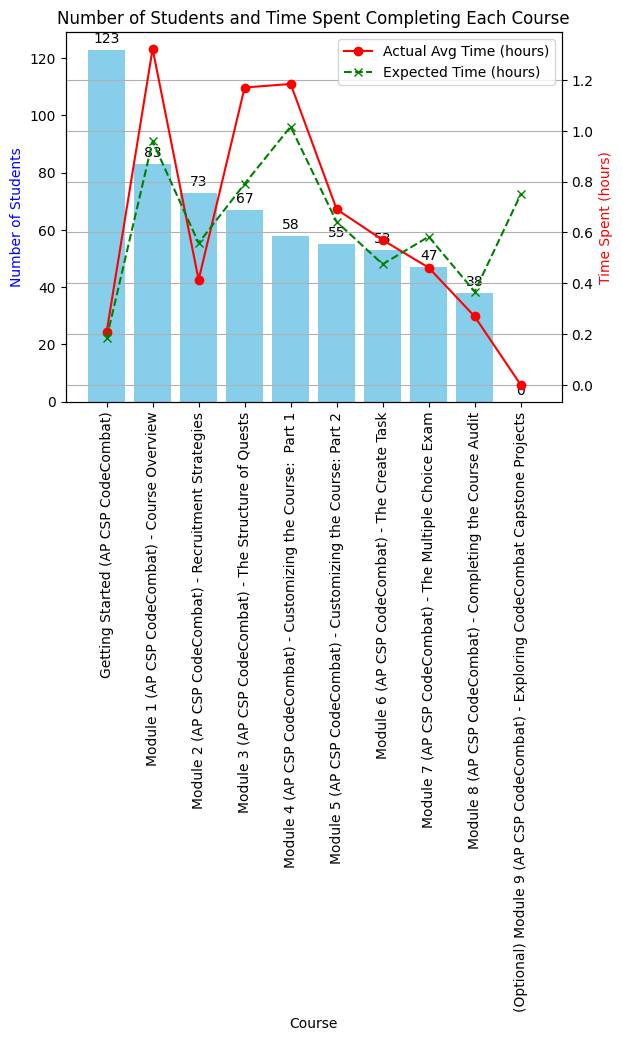

In [38]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[df['Progress (Percent)'] == 100]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts()

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Reindex the series to match the predefined course order
course_counts = course_counts.reindex(course_order).fillna(0)
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)

# Create the bar plot for the number of students
fig, ax1 = plt.subplots()
ax1.bar(course_order, course_counts.values, color='skyblue')
ax1.set_xlabel('Course')
ax1.set_ylabel('Number of Students', color='blue')
ax1.set_title('Number of Students and Time Spent Completing Each Course')
ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels

# Annotate the bars with their values
for i, v in enumerate(course_counts):
    ax1.annotate(str(int(v)), 
                 (i, v), 
                 ha='center', 
                 va='bottom', 
                 xytext=(0, 3), 
                 textcoords='offset points')

# Create a secondary y-axis for the average time spent
ax2 = ax1.twinx()
ax2.plot(course_order, average_time_hours.values, color='red', marker='o', label='Actual Avg Time (hours)')
ax2.plot(course_order, expected_time_series.values, color='green', marker='x', linestyle='--', label='Expected Time (hours)')
ax2.set_ylabel('Time Spent (hours)', color='red')

# Show grid only for secondary axis to avoid clutter
ax2.grid(True)

# Add legend for clarity
ax2.legend(loc='upper right')

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


### No. of Students who started but didn't complete, Avg Time Spent, and Expected Time Spent

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/3214399882.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/3214399882.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for label rotation


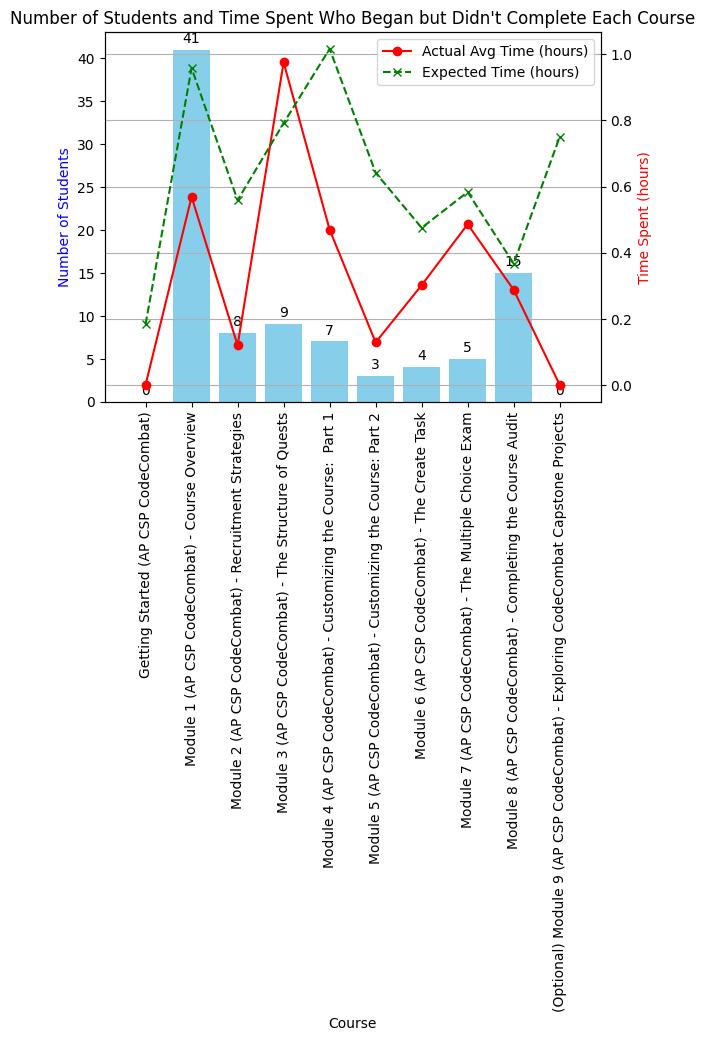

In [64]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

df_filtered = df[( df['Progress (Percent)'] > 0 ) & ( df['Progress (Percent)'] < 100 )]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts()

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Reindex the series to match the predefined course order
course_counts = course_counts.reindex(course_order).fillna(0)
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)

# Create the bar plot for the number of students
fig, ax1 = plt.subplots()
ax1.bar(course_order, course_counts.values, color='skyblue')
ax1.set_xlabel('Course')
ax1.set_ylabel('Number of Students', color='blue')
ax1.set_title("Number of Students and Time Spent Who Began but Didn't Complete Each Course")
ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels

# Annotate the bars with their values
for i, v in enumerate(course_counts):
    ax1.annotate(str(int(v)), 
                 (i, v), 
                 ha='center', 
                 va='bottom', 
                 xytext=(0, 3), 
                 textcoords='offset points')

# Create a secondary y-axis for the average time spent
ax2 = ax1.twinx()
ax2.plot(course_order, average_time_hours.values, color='red', marker='o', label='Actual Avg Time (hours)')
ax2.plot(course_order, expected_time_series.values, color='green', marker='x', linestyle='--', label='Expected Time (hours)')
ax2.set_ylabel('Time Spent (hours)', color='red')

# Show grid only for secondary axis to avoid clutter
ax2.grid(True)

# Add legend for clarity
ax2.legend(loc='upper right')

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


### No. of Students with Non-Zero Progress in Each course, Avg Time Spent, and Expected Time Spent

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/3869159329.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/3869159329.py:50: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for label rotation


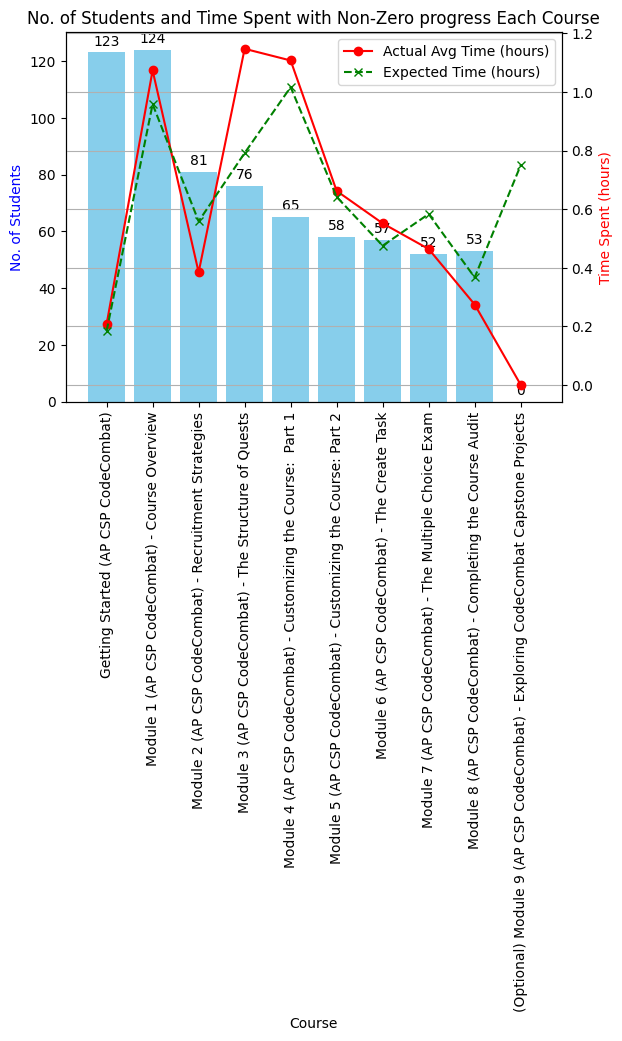

In [39]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with > 0 progress
df_filtered = df[df['Progress (Percent)'] > 0]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts()

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Reindex the series to match the predefined course order
course_counts = course_counts.reindex(course_order).fillna(0)
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)

# Create the bar plot for the number of students
fig, ax1 = plt.subplots()
ax1.bar(course_order, course_counts.values, color='skyblue')
ax1.set_xlabel('Course')
ax1.set_ylabel('No. of Students', color='blue')
ax1.set_title('No. of Students and Time Spent with Non-Zero progress Each Course')
ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels

# Annotate the bars with their values
for i, v in enumerate(course_counts):
    ax1.annotate(str(int(v)), 
                 (i, v), 
                 ha='center', 
                 va='bottom', 
                 xytext=(0, 3), 
                 textcoords='offset points')

# Create a secondary y-axis for the average time spent
ax2 = ax1.twinx()
ax2.plot(course_order, average_time_hours.values, color='red', marker='o', label='Actual Avg Time (hours)')
ax2.plot(course_order, expected_time_series.values, color='green', marker='x', linestyle='--', label='Expected Time (hours)')
ax2.set_ylabel('Time Spent (hours)', color='red')

# Show grid only for secondary axis to avoid clutter
ax2.grid(True)

# Add legend for clarity
ax2.legend(loc='upper right')

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/2814122638.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/2814122638.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for label rotation


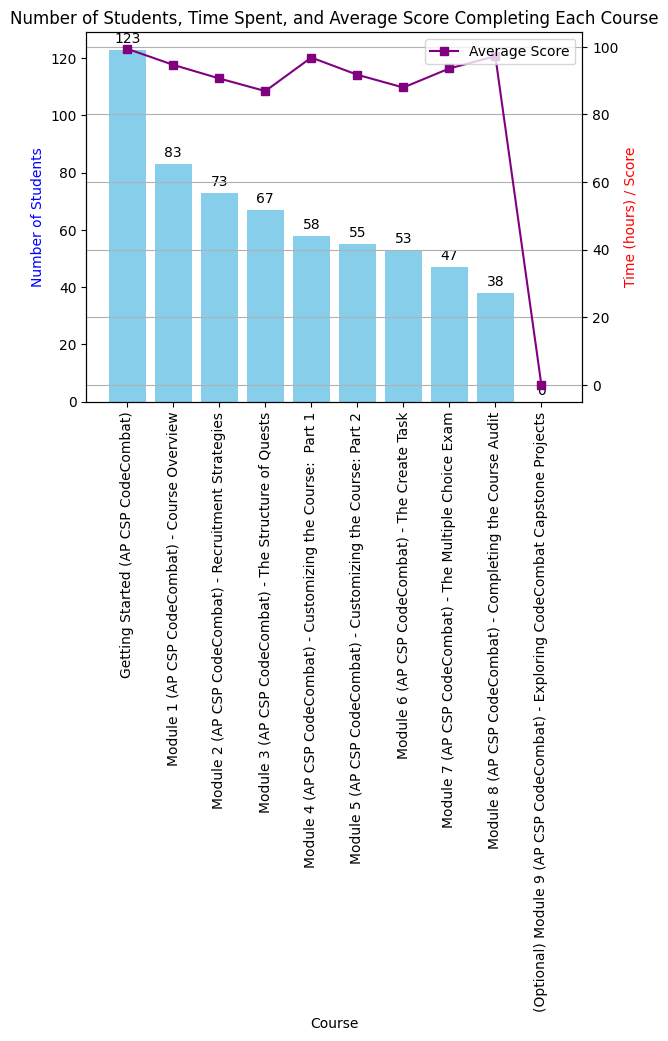

In [44]:
# Assuming df is your DataFrame and it includes an 'Average Score' column

# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[df['Progress (Percent)'] == 100]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts()

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Calculate average scores per course
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Reindex the series to match the predefined course order
course_counts = course_counts.reindex(course_order).fillna(0)
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)
average_scores = average_scores.reindex(course_order).fillna(0)

# Create the bar plot for the number of students
fig, ax1 = plt.subplots()
ax1.bar(course_order, course_counts.values, color='skyblue')
ax1.set_xlabel('Course')
ax1.set_ylabel('Number of Students', color='blue')
ax1.set_title('Number of Students, Time Spent, and Average Score Completing Each Course')
ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels

# Annotate the bars with their values
for i, v in enumerate(course_counts):
    ax1.annotate(str(int(v)), 
                 (i, v), 
                 ha='center', 
                 va='bottom', 
                 xytext=(0, 3), 
                 textcoords='offset points')

# Create a secondary y-axis for the average time spent and scores
ax2 = ax1.twinx()
# ax2.plot(course_order, average_time_hours.values, color='red', marker='o', label='Actual Avg Time (hours)')
# ax2.plot(course_order, expected_time_series.values, color='green', marker='x', linestyle='--', label='Expected Time (hours)')
ax2.plot(course_order, average_scores.values, color='purple', marker='s', linestyle='-', label='Average Score')
ax2.set_ylabel('Time (hours) / Score', color='red')

# Show grid only for secondary axis to avoid clutter
ax2.grid(True)

# Add legend for clarity
ax2.legend(loc='upper right')

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


### Average Time Spent, Expected Time, and Average Score per Course for 100% Progress

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_12193/1051205742.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_12193/1051205742.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for label rotation


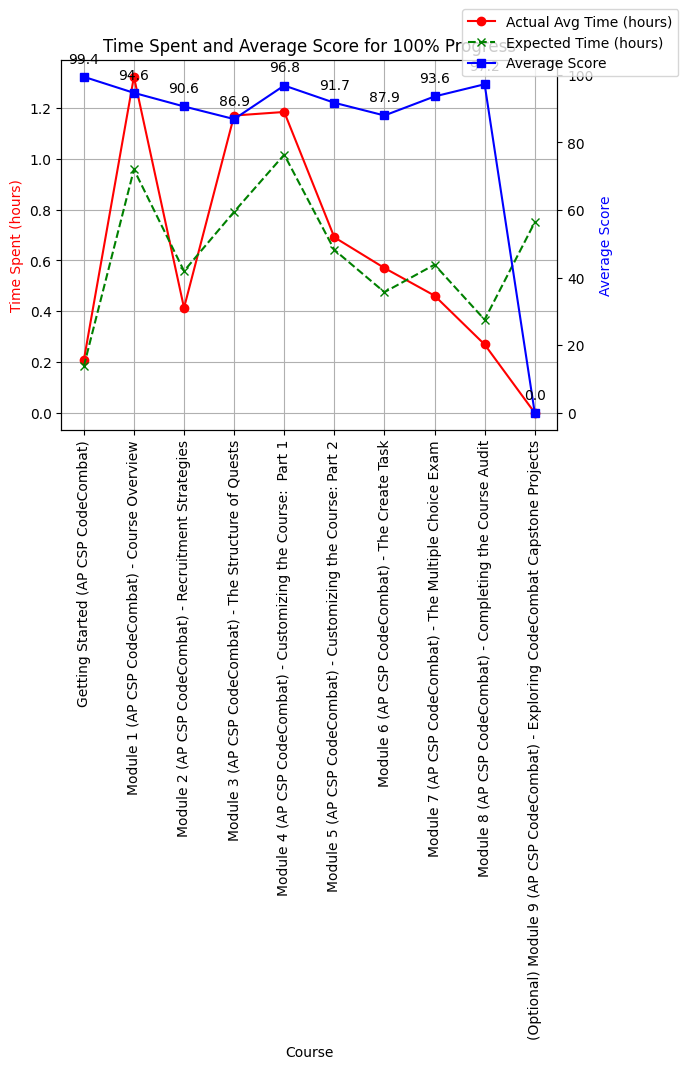

In [3]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[df['Progress (Percent)'] == 100]

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Calculate average scores per course
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Reindex the series to match the predefined course order
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)
average_scores = average_scores.reindex(course_order).fillna(0)

# Create the plot with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plotting average time spent and expected time on ax1
ax1.plot(course_order, average_time_hours.values, color='red', marker='o', linestyle='-', label='Actual Avg Time (hours)')
ax1.plot(course_order, expected_time_series.values, color='green', marker='x', linestyle='--', label='Expected Time (hours)')
ax1.set_xlabel('Course')
ax1.set_ylabel('Time Spent (hours)', color='red')
ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels

# Plotting average score on ax2
ax2.plot(course_order, average_scores.values, color='blue', marker='s', linestyle='-', label='Average Score')
ax2.set_ylabel('Average Score', color='blue')

# Annotate each point on the average score line
for i, score in enumerate(average_scores.values):
    ax2.annotate(f'{score:.1f}', # formatted to one decimal place
                 (course_order[i], score),
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Grid, legend and layout adjustments
ax1.grid(True)
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Time Spent and Average Score for 100% Progress')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_12193/4192353122.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order_short, rotation='vertical')


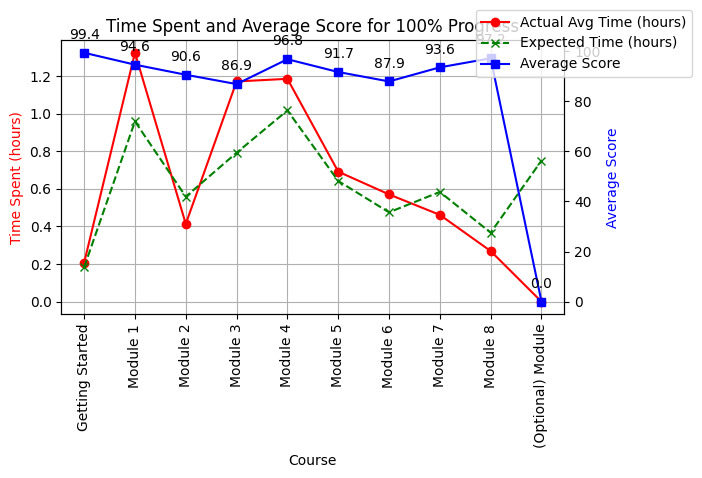

In [4]:
# Sample data processing code (adjust according to your actual data context)
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

df_filtered = df[df['Progress (Percent)'] == 100]

average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Shorten course names to first two words
course_order_short = [' '.join(name.split()[:2]) for name in course_order]

# Reindex and calculate the necessary series
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)
average_scores = average_scores.reindex(course_order).fillna(0)

# Create the plot with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plotting average time spent and expected time
ax1.plot(course_order_short, average_time_hours.values, 'ro-', label='Actual Avg Time (hours)')
ax1.plot(course_order_short, expected_time_series.values, 'gx--', label='Expected Time (hours)')
ax1.set_xlabel('Course')
ax1.set_ylabel('Time Spent (hours)', color='red')
ax1.set_xticklabels(course_order_short, rotation='vertical')

# Plotting average score
ax2.plot(course_order_short, average_scores.values, 'bs-', label='Average Score')
ax2.set_ylabel('Average Score', color='blue')

# Annotate each point on the average score line
for i, score in enumerate(average_scores.values):
    ax2.annotate(f'{score:.1f}', (course_order_short[i], score),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Grid, legend and layout adjustments
ax1.grid(True)
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Time Spent and Average Score for 100% Progress')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


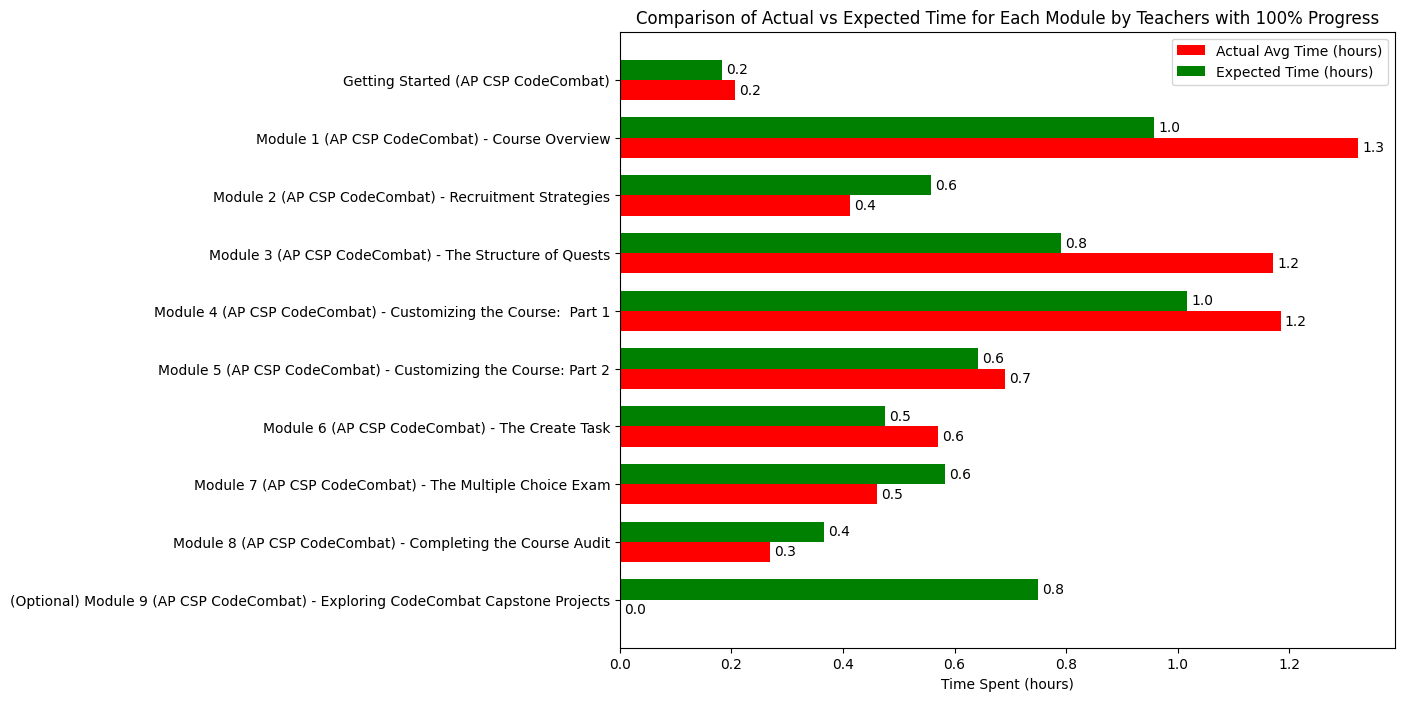

In [84]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[df['Progress (Percent)'] == 100]

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Calculate average scores per course
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys
course_order = list(expected_time_spent.keys())
course_indices = np.arange(len(course_order))  # Numerical indices for plotting

# Reindexing data to ensure it matches course order and handling missing data
average_time_hours = [average_time_hours.get(course, 0) for course in reversed(course_order)]
expected_time_hours = [expected_time_hours[course] for course in reversed(course_order)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Horizontal bar plot for time spent
bar_width = 0.35
rects1 = ax.barh(course_indices - bar_width/2, average_time_hours, height=bar_width, color='red', label='Actual Avg Time (hours)')
rects2 = ax.barh(course_indices + bar_width/2, expected_time_hours, height=bar_width, color='green', label='Expected Time (hours)')

ax.set_yticks(course_indices)
ax.set_yticklabels(reversed(course_order))  # Reversing the course order in labels
ax.set_xlabel('Time Spent (hours)')
ax.set_title('Comparison of Actual vs Expected Time for Each Module by Teachers with 100% Progress')
ax.legend()

# Function to attach a text label above each bar
def add_labels(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

# Adding labels to the bars
add_labels(rects1)
add_labels(rects2)

plt.show()


### Average Time Spent, Expected Time, and Average Score per Course for Non-Zero Progress

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/2588139602.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_31721/2588139602.py:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to make room for label rotation


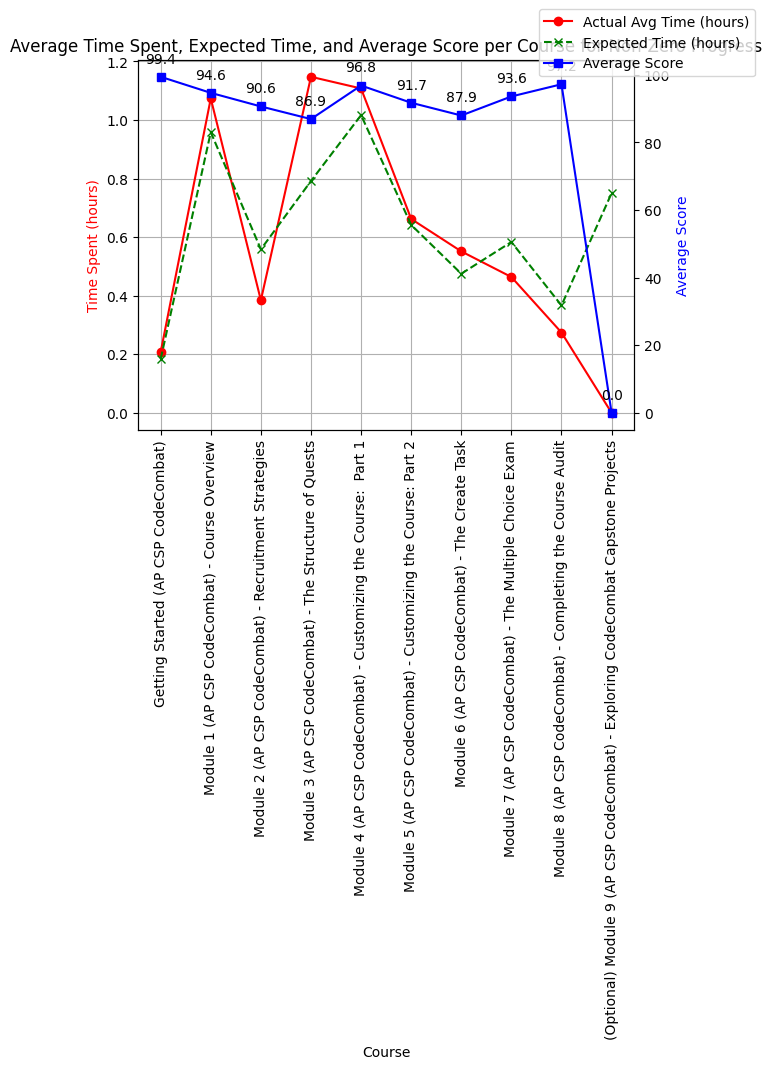

In [49]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[df['Progress (Percent)'] > 0]

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Calculate average scores per course
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys, ensuring all courses are included
course_order = list(expected_time_spent.keys())

# Reindex the series to match the predefined course order
average_time_hours = average_time_hours.reindex(course_order).fillna(0)
expected_time_series = pd.Series(expected_time_hours).reindex(course_order).fillna(0)
average_scores = average_scores.reindex(course_order).fillna(0)

# Create the plot with two y-axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plotting average time spent and expected time on ax1
ax1.plot(course_order, average_time_hours.values, color='red', marker='o', linestyle='-', label='Actual Avg Time (hours)')
ax1.plot(course_order, expected_time_series.values, color='green', marker='x', linestyle='--', label='Expected Time (hours)')
ax1.set_xlabel('Course')
ax1.set_ylabel('Time Spent (hours)', color='red')
ax1.set_xticklabels(course_order, rotation='vertical')  # Rotate x-axis labels

# Plotting average score on ax2
ax2.plot(course_order, average_scores.values, color='blue', marker='s', linestyle='-', label='Average Score')
ax2.set_ylabel('Average Score', color='blue')

# Annotate each point on the average score line
for i, score in enumerate(average_scores.values):
    ax2.annotate(f'{score:.1f}', # formatted to one decimal place
                 (course_order[i], score),
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Grid, legend and layout adjustments
ax1.grid(True)
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Average Time Spent, Expected Time, and Average Score per Course for Non-Zero Progress')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()


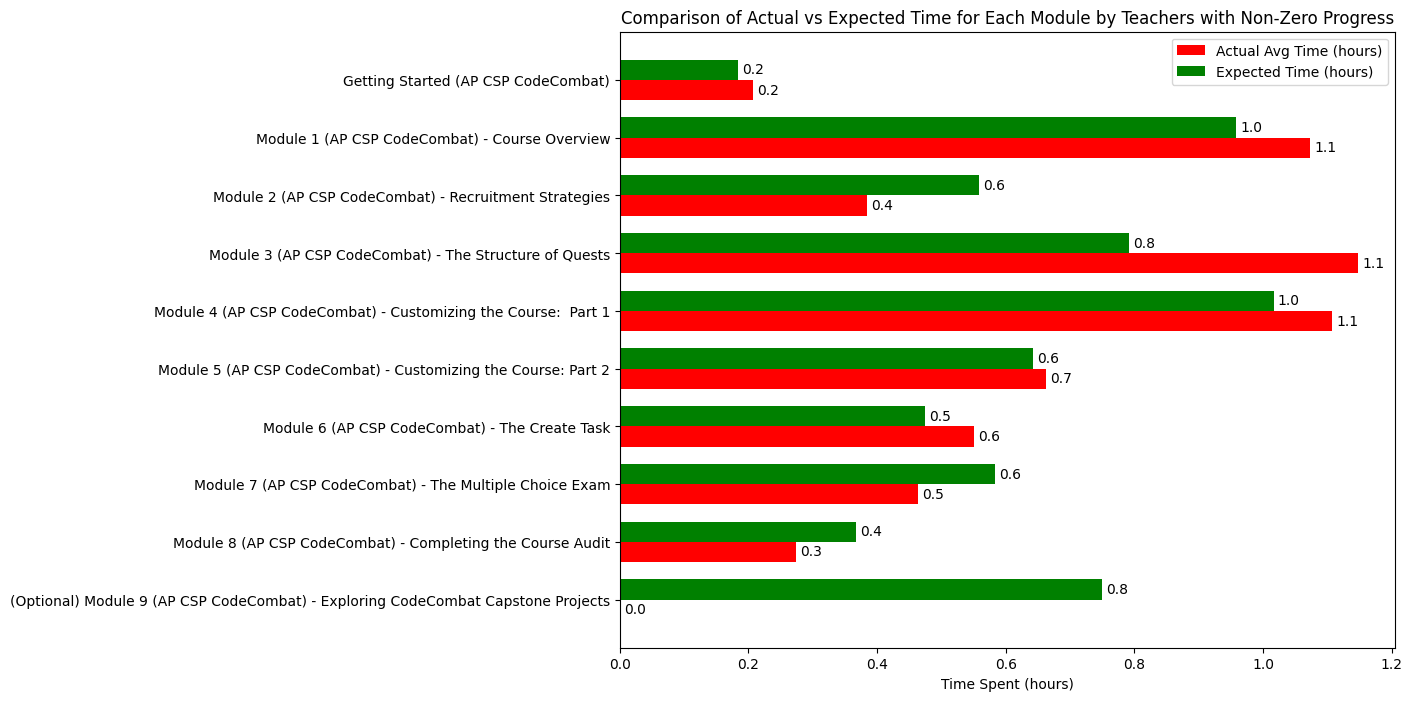

In [86]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[df['Progress (Percent)'] > 0]

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Calculate average scores per course
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys
course_order = list(expected_time_spent.keys())
course_indices = np.arange(len(course_order))  # Numerical indices for plotting

# Reindexing data to ensure it matches course order and handling missing data
average_time_hours = [average_time_hours.get(course, 0) for course in reversed(course_order)]
expected_time_hours = [expected_time_hours[course] for course in reversed(course_order)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Horizontal bar plot for time spent
bar_width = 0.35
rects1 = ax.barh(course_indices - bar_width/2, average_time_hours, height=bar_width, color='red', label='Actual Avg Time (hours)')
rects2 = ax.barh(course_indices + bar_width/2, expected_time_hours, height=bar_width, color='green', label='Expected Time (hours)')

ax.set_yticks(course_indices)
ax.set_yticklabels(reversed(course_order))  # Reversing the course order in labels
ax.set_xlabel('Time Spent (hours)')
ax.set_title('Comparison of Actual vs Expected Time for Each Module by Teachers with Non-Zero Progress')
ax.legend()

# Function to attach a text label above each bar
def add_labels(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

# Adding labels to the bars
add_labels(rects1)
add_labels(rects2)

plt.show()


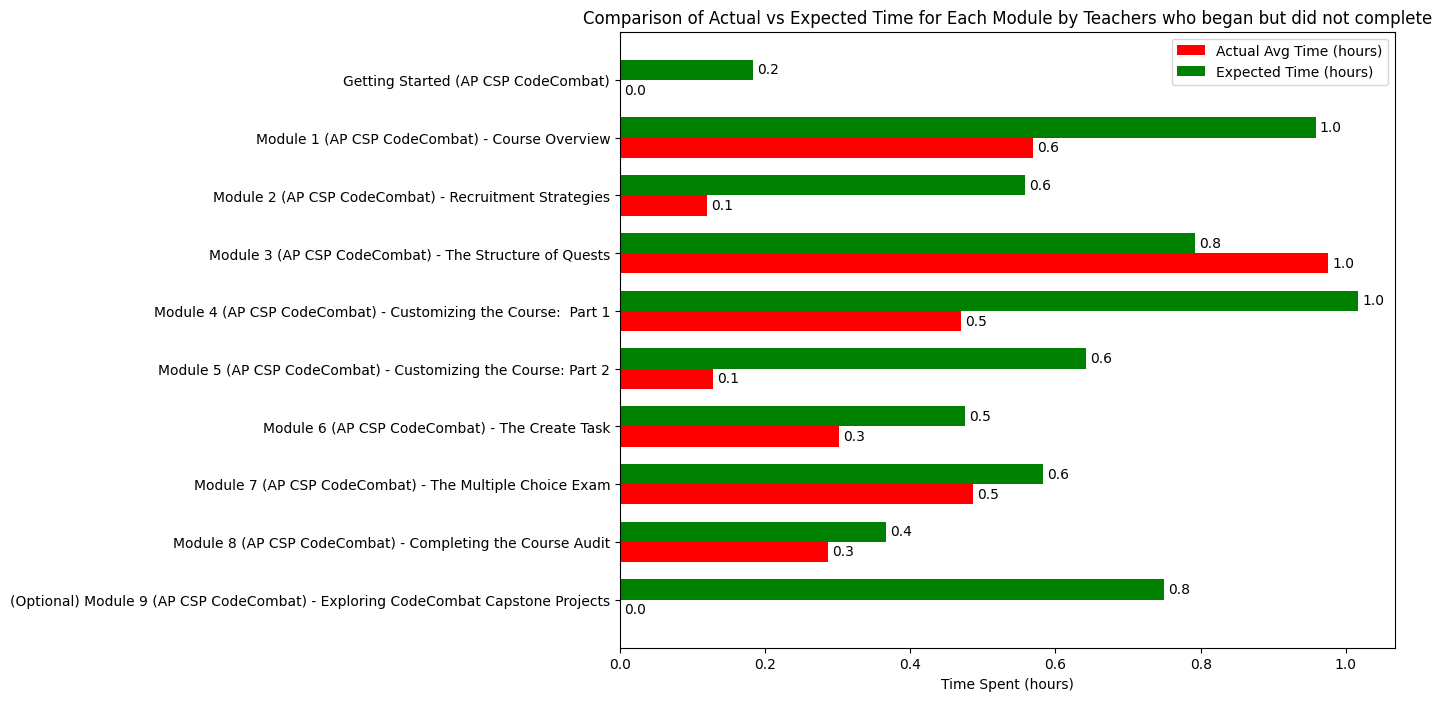

In [87]:
# Convert expected times to hours
expected_time_hours = {k: v / 60 for k, v in expected_time_spent.items()}

# Filter the DataFrame for users with 100% progress
df_filtered = df[(df['Progress (Percent)'] > 0) & (df['Progress (Percent)'] < 100)]

# Calculate average time spent per course (convert minutes to hours for readability)
average_time_hours = df_filtered.groupby('Course')['Time Spent (minutes)'].mean() / 60

# Calculate average scores per course
average_scores = df_filtered.groupby('Course')['Average Score'].mean()

# Predefined order from the expected time dictionary keys
course_order = list(expected_time_spent.keys())
course_indices = np.arange(len(course_order))  # Numerical indices for plotting

# Reindexing data to ensure it matches course order and handling missing data
average_time_hours = [average_time_hours.get(course, 0) for course in reversed(course_order)]
expected_time_hours = [expected_time_hours[course] for course in reversed(course_order)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Horizontal bar plot for time spent
bar_width = 0.35
rects1 = ax.barh(course_indices - bar_width/2, average_time_hours, height=bar_width, color='red', label='Actual Avg Time (hours)')
rects2 = ax.barh(course_indices + bar_width/2, expected_time_hours, height=bar_width, color='green', label='Expected Time (hours)')

ax.set_yticks(course_indices)
ax.set_yticklabels(reversed(course_order))  # Reversing the course order in labels
ax.set_xlabel('Time Spent (hours)')
ax.set_title('Comparison of Actual vs Expected Time for Each Module by Teachers who began but did not complete')
ax.legend()

# Function to attach a text label above each bar
def add_labels(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.1f}',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

# Adding labels to the bars
add_labels(rects1)
add_labels(rects2)

plt.show()


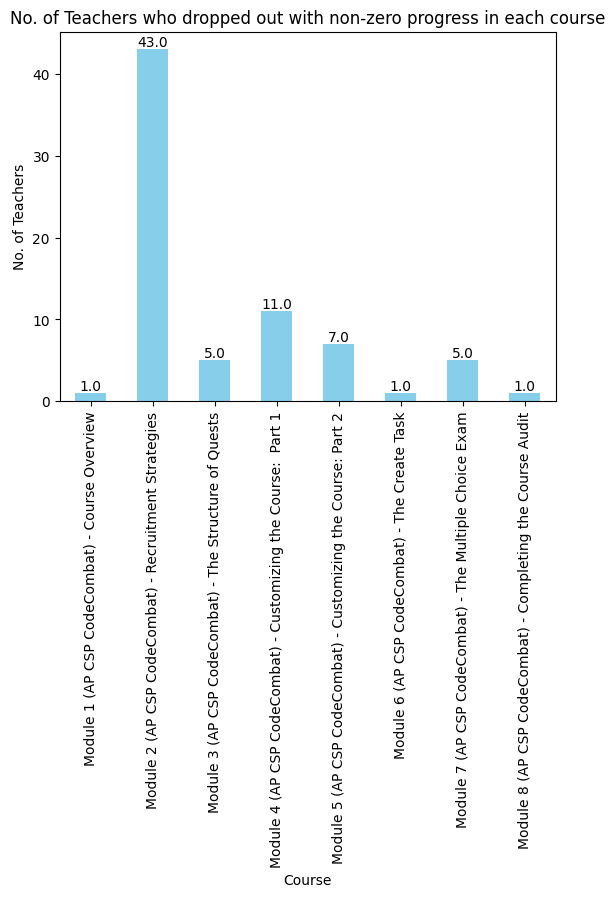

In [66]:
# Filter the DataFrame
df_filtered = df[df['Progress (Percent)'] > 0]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts().sort_index()

# Calculate the differences between consecutive courses
course_differences = course_counts.diff().iloc[1:]

# Convert differences to absolute values
course_differences_abs = course_differences.abs()

# Create the bar plot for the absolute differences
ax = course_differences_abs.plot(kind='bar', color='skyblue')
plt.xlabel('Course')
plt.ylabel('No. of Teachers')
plt.title('No. of Teachers who dropped out with non-zero progress in each course')

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.show()


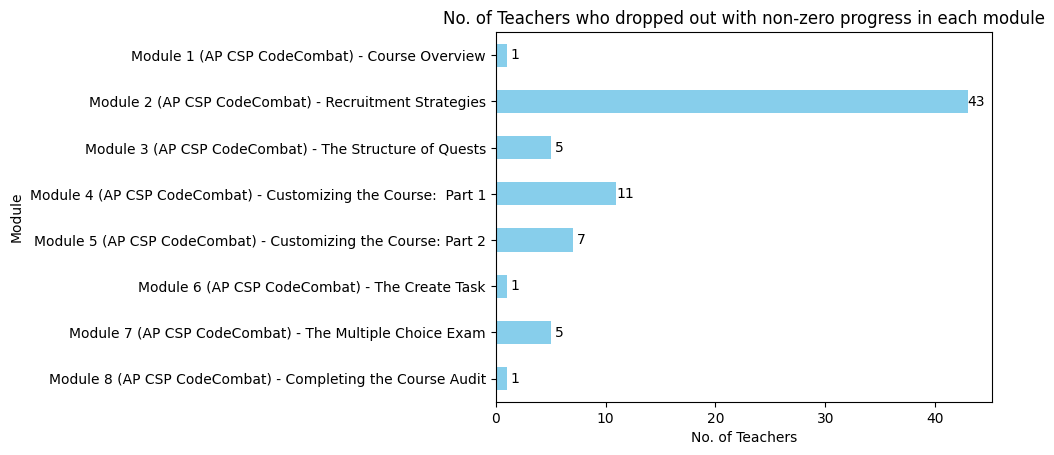

In [78]:
# Filter the DataFrame
df_filtered = df[df['Progress (Percent)'] > 0]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts().sort_index()

# Calculate the differences between consecutive courses
course_differences = course_counts.diff().iloc[1:]

# Convert differences to absolute values
course_differences_abs = course_differences.abs()

# Reverse the order of the courses for plotting
course_differences_abs = course_differences_abs.iloc[::-1]

# Create the bar plot for the absolute differences
ax = course_differences_abs.plot(kind='barh', color='skyblue')
plt.ylabel('Module')
plt.xlabel('No. of Teachers')
plt.title('No. of Teachers who dropped out with non-zero progress in each module')

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(int(p.get_width()),  # Changed to get_width() because it's horizontal now
                (p.get_width(), p.get_y() + p.get_height() / 2.),  # Adjust text placement for horizontal layout
                ha = 'center', 
                va = 'center', 
                xytext = (6, 0),  # Offset to push text right slightly from end of bar
                textcoords = 'offset points')

plt.show()


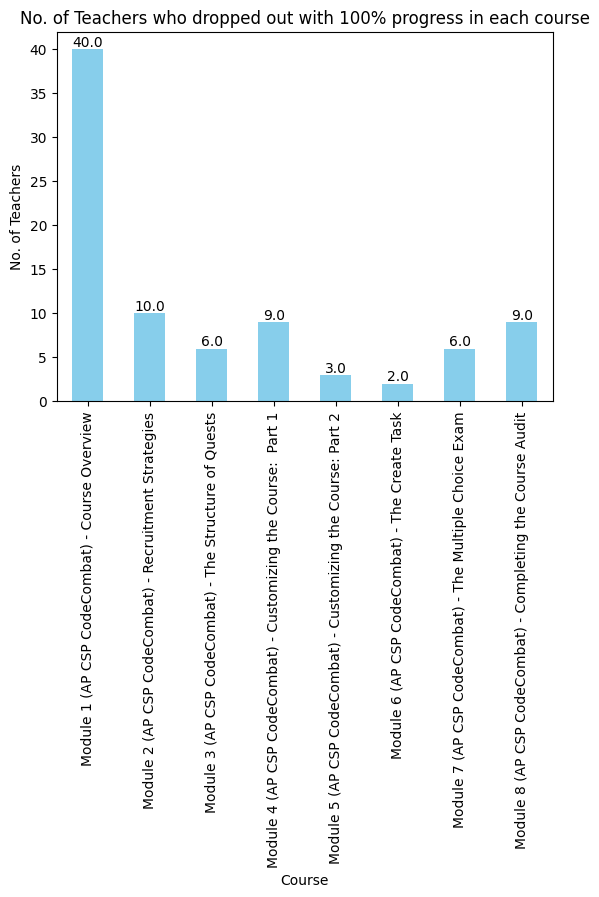

In [67]:
# Filter the DataFrame
df_filtered = df[df['Progress (Percent)'] == 100]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts().sort_index()

# Calculate the differences between consecutive courses
course_differences = course_counts.diff().iloc[1:]

# Convert differences to absolute values
course_differences_abs = course_differences.abs()

# Create the bar plot for the absolute differences
ax = course_differences_abs.plot(kind='bar', color='skyblue')
plt.xlabel('Course')
plt.ylabel('No. of Teachers')
plt.title('No. of Teachers who dropped out with 100% progress in each course')

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.show()


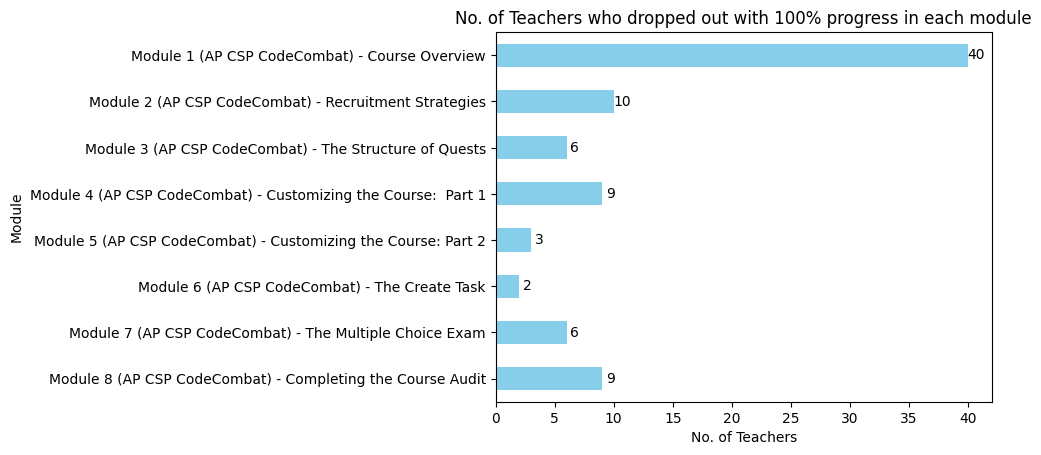

In [71]:
# Filter the DataFrame
df_filtered = df[df['Progress (Percent)'] == 100]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts().sort_index()

# Calculate the differences between consecutive courses
course_differences = course_counts.diff().iloc[1:]

# Convert differences to absolute values
course_differences_abs = course_differences.abs()

# Reverse the order of the courses for plotting
course_differences_abs = course_differences_abs.iloc[::-1]

# Create the horizontal bar plot for the absolute differences
ax = course_differences_abs.plot(kind='barh', color='skyblue')
plt.ylabel('Module')
plt.xlabel('No. of Teachers')
plt.title('No. of Teachers who dropped out with 100% progress in each module')

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(int(p.get_width()),  # Changed to get_width() because it's horizontal now
                (p.get_width(), p.get_y() + p.get_height() / 2.),  # Adjust text placement for horizontal layout
                ha = 'center', 
                va = 'center', 
                xytext = (6, 0),  # Offset to push text right slightly from end of bar
                textcoords = 'offset points')

plt.show()


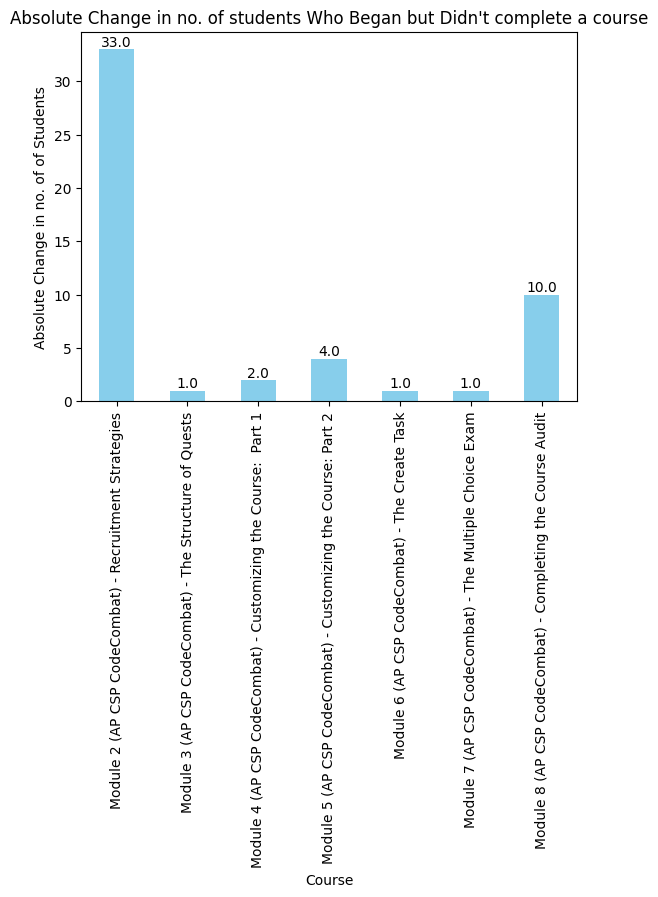

In [65]:
# Filter the DataFrame
df_filtered = df[( df['Progress (Percent)'] > 0 ) & ( df['Progress (Percent)'] < 100 )]

# Count the occurrences for each course
course_counts = df_filtered['Course'].value_counts().sort_index()

# Calculate the differences between consecutive courses
course_differences = course_counts.diff().iloc[1:]

# Convert differences to absolute values
course_differences_abs = course_differences.abs()

# Create the bar plot for the absolute differences
ax = course_differences_abs.plot(kind='bar', color='skyblue')
plt.xlabel('Course')
plt.ylabel('Absolute Change in no. of of Students')
plt.title("Absolute Change in no. of students Who Began but Didn't complete a course")

# Annotate the bars with their values
for p in ax.patches:
    ax.annotate(p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.show()


In [97]:
# Create subplots
# fig, axes = plt.subplots(nrows=len(courses), ncols=1, figsize=(6, 5 * len(courses)))

# if len(courses) == 1:
#     axes = [axes]  # Make sure axes is iterable

# Iterate through each course
# for course, ax in zip(courses, axes):
for course in courses:
    course_data = df[df['Course'] == course]
    
    # Calculate Pearson Correlation
    correlation, p_value = pearsonr(course_data['Time Spent (minutes)'], course_data['Progress (Percent)'])
    # print(f"{course} - Pearson Correlation: {correlation:.2f}, p-value: {p_value:.8f}")
    print(f"{course} - Pearson Correlation: {correlation}, p-value: {p_value}")
    
#     # Plot Scatter Plot
#     sns.scatterplot(ax=ax, data=course_data, x='Time Spent (minutes)', y='Progress (Percent)')
#     ax.set_title(f'{course} - Scatter Plot (Correlation: {correlation:.2f}, p-value: {p_value:.4f})')
    
#     # Linear Regression
#     X = course_data['Time Spent (minutes)']
#     y = course_data['Progress (Percent)']
#     X = sm.add_constant(X)  # adding a constant
#     model = sm.OLS(y, X).fit()
    
#     # Add regression line
#     sns.regplot(ax=ax, x='Time Spent (minutes)', y='Progress (Percent)', data=course_data, scatter=False, line_kws={"color": "red"})
    
#     print(f"{course} - Regression Analysis Results:")
#     print(model.summary())
#     print("\n\n")

# plt.tight_layout()
# plt.show()

Getting Started (AP CSP CodeCombat) - Pearson Correlation: 0.26102797993672144, p-value: 5.503804325420768e-05
Module 1 (AP CSP CodeCombat) - Course Overview - Pearson Correlation: 0.636302305593755, p-value: 7.587082113058547e-28
Module 2 (AP CSP CodeCombat) - Recruitment Strategies - Pearson Correlation: 0.44816006220251253, p-value: 6.528815236395744e-13
Module 3 (AP CSP CodeCombat) - The Structure of Quests - Pearson Correlation: 0.6616561167485204, p-value: 1.0234339451287198e-30
Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1 - Pearson Correlation: 0.6959047583000144, p-value: 4.5565006457171715e-35
Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2 - Pearson Correlation: 0.7526565755561654, p-value: 8.219177449227995e-44
Module 6 (AP CSP CodeCombat) - The Create Task - Pearson Correlation: 0.7517999861164703, p-value: 1.159336119292811e-43
Module 7 (AP CSP CodeCombat) - The Multiple Choice Exam - Pearson Correlation: 0.7356169205439796, p-value: 5.97524

In [3]:
data = []
for i in range(len(courses)-1):
	data.append([courses[i], courses[i+1], 0])
# print(data)

for user in df['UserID'].unique():
	for i in range(len(courses)-1):
		course_i_progress = df[(df['UserID'] == user) & (df['Course'] == courses[i])]['Progress (Percent)'].values
		# print(user, courses[i], course_i_progress)

		if len(course_i_progress) == 1 and course_i_progress[0] == 100:
			data[i][2] += 1
		# break

print(data)

for i in range(1, len(data)):
	print(f"Drop-off from {data[i][0]} to {data[i][1]} = {data[i-1][2] - data[i][2]}")

[['Getting Started (AP CSP CodeCombat)', 'Module 1 (AP CSP CodeCombat) - Course Overview', 123], ['Module 1 (AP CSP CodeCombat) - Course Overview', 'Module 2 (AP CSP CodeCombat) - Recruitment Strategies', 83], ['Module 2 (AP CSP CodeCombat) - Recruitment Strategies', 'Module 3 (AP CSP CodeCombat) - The Structure of Quests', 73], ['Module 3 (AP CSP CodeCombat) - The Structure of Quests', 'Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1', 67], ['Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1', 'Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2', 58], ['Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2', 'Module 6 (AP CSP CodeCombat) - The Create Task', 55], ['Module 6 (AP CSP CodeCombat) - The Create Task', 'Module 7 (AP CSP CodeCombat) - The Multiple Choice Exam', 53], ['Module 7 (AP CSP CodeCombat) - The Multiple Choice Exam', 'Module 8 (AP CSP CodeCombat) - Completing the Course Audit', 47]]
Drop-off from Module 1 (AP CSP CodeComb

In [14]:
def get_user_course_progress(df, user, course):
	progress = df[(df['UserID'] == user) & (df['Course'] == course)]['Progress (Percent)'].values
	if len(progress) == 1:
		return progress[0]
	return 0